In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/PE-SC.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['PE-SC（期货指数）'].last_valid_index()   

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,PE-SC（期货指数）,结算价:原油指数,PE-SC（期货指数）拟合残差/结算价:原油指数
2025-11-20,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN
2025-11-24,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN


In [5]:
sheet2 = pd.ExcelFile('eta/PE-SC拟合残差_SC_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,预测值
20,2025-10-29,-619.5
21,2025-10-29,-625.8
19,2025-10-30,-624.8
18,2025-10-31,-607.7
17,2025-11-03,-574.1


In [6]:
sheet1 = pd.ExcelFile('eta/结算价-原油指数_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['结算价:原油指数'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,结算价:原油指数_预测
19,2025-10-29,549.010232
18,2025-10-30,556.441977
17,2025-10-31,563.902832
16,2025-11-03,569.805434
15,2025-11-04,578.035595


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '结算价:原油指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['结算价:原油指数'] = sheet_daily['结算价:原油指数'].fillna(sheet_daily['结算价:原油指数_预测'])
sheet_daily = sheet_daily.drop(columns=['结算价:原油指数_预测'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PE-SC（期货指数）拟合残差/结算价:原油指数'] = sheet_daily['PE-SC（期货指数）拟合残差/结算价:原油指数'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet_daily.tail()

,Date,PE-SC（期货指数）,结算价:原油指数,PE-SC（期货指数）拟合残差/结算价:原油指数
1881,2025-11-20,NaN,584.418704,-386.7
1882,2025-11-21,NaN,583.016230,-381.8
1883,2025-11-24,NaN,564.614135,-363.3
1884,2025-11-25,NaN,565.709524,-355.3
1885,2025-11-26,NaN,NaN,-634.4


In [8]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['PE-SC（期货指数）_预测'] = -4.7737 * sheet_daily['结算价:原油指数'] + 6339.1023 + sheet_daily['PE-SC（期货指数）拟合残差/结算价:原油指数']
sheet_daily.tail()

,Date,PE-SC（期货指数）,结算价:原油指数,PE-SC（期货指数）拟合残差/结算价:原油指数,PE-SC（期货指数）_预测
1881,2025-11-20,NaN,584.418704,-386.7,3162.562733
1882,2025-11-21,NaN,583.016230,-381.8,3174.157723
1883,2025-11-24,NaN,564.614135,-363.3,3280.503804
1884,2025-11-25,NaN,565.709524,-355.3,3283.274745
1885,2025-11-26,NaN,NaN,-634.4,NaN


---

In [9]:
last_day = sheet_daily['Date'][sheet_daily['PE-SC（期货指数）'].last_valid_index()]

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'PE-SC（期货指数）']]
historical.columns = ['Date', 'PE-SC（期货指数）']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', 'PE-SC（期货指数）_预测']]
forecast.columns = ['Date', 'PE-SC（期货指数）_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 删除纯苯-Brent价差和纯苯-Brent价差_预测都为nan的行
merged_df_daily = merged_df_daily.dropna(subset=['PE-SC（期货指数）', 'PE-SC（期货指数）_预测'], how='all')
merged_df_daily.to_excel('eta/PE-SC（期货指数）_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily.head()

,Date,PE-SC（期货指数）,PE-SC（期货指数）_预测
1884,2025/11/25,NaN,3283.274745
1883,2025/11/24,NaN,3280.503804
1882,2025/11/21,NaN,3174.157723
1881,2025/11/20,NaN,3162.562733
1880,2025/11/19,NaN,3153.278534


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'PE-SC（期货指数）']]
historical_monthly.columns = ['Date', 'PE-SC（期货指数）']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', 'PE-SC（期货指数）_预测']]
forecast_monthly.columns = ['Date', 'PE-SC（期货指数）_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly = merged_df_monthly.dropna(subset=['PE-SC（期货指数）', 'PE-SC（期货指数）_预测'], how='all')
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/PE-SC（期货指数）_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,PE-SC（期货指数）,PE-SC（期货指数）_预测
93,2025/11/30,NaN,3051.513839
92,2025/10/31,3331.514286,3273.897007
91,2025/09/30,3315.763636,3315.774915
90,2025/08/31,3412.380952,3412.392355
89,2025/07/31,3266.008696,3266.020401


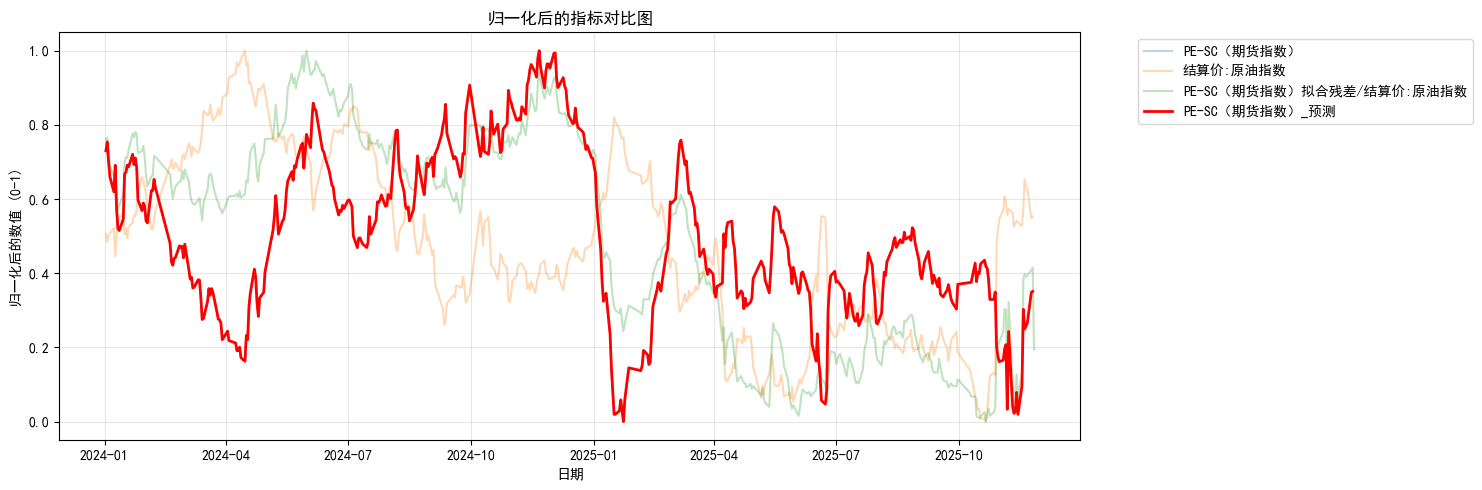

In [12]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()
normalized_df1 = sheet_daily.copy()
# 筛选2024年及以后的数据
normalized_df = normalized_df[normalized_df['Date'] >= '2024-01-01'].copy()
normalized_df1 = normalized_df1[normalized_df1['Date'] >= '2024-01-01'].copy()
# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df1[columns_to_normalize])


# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == 'PE-SC（期货指数）_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



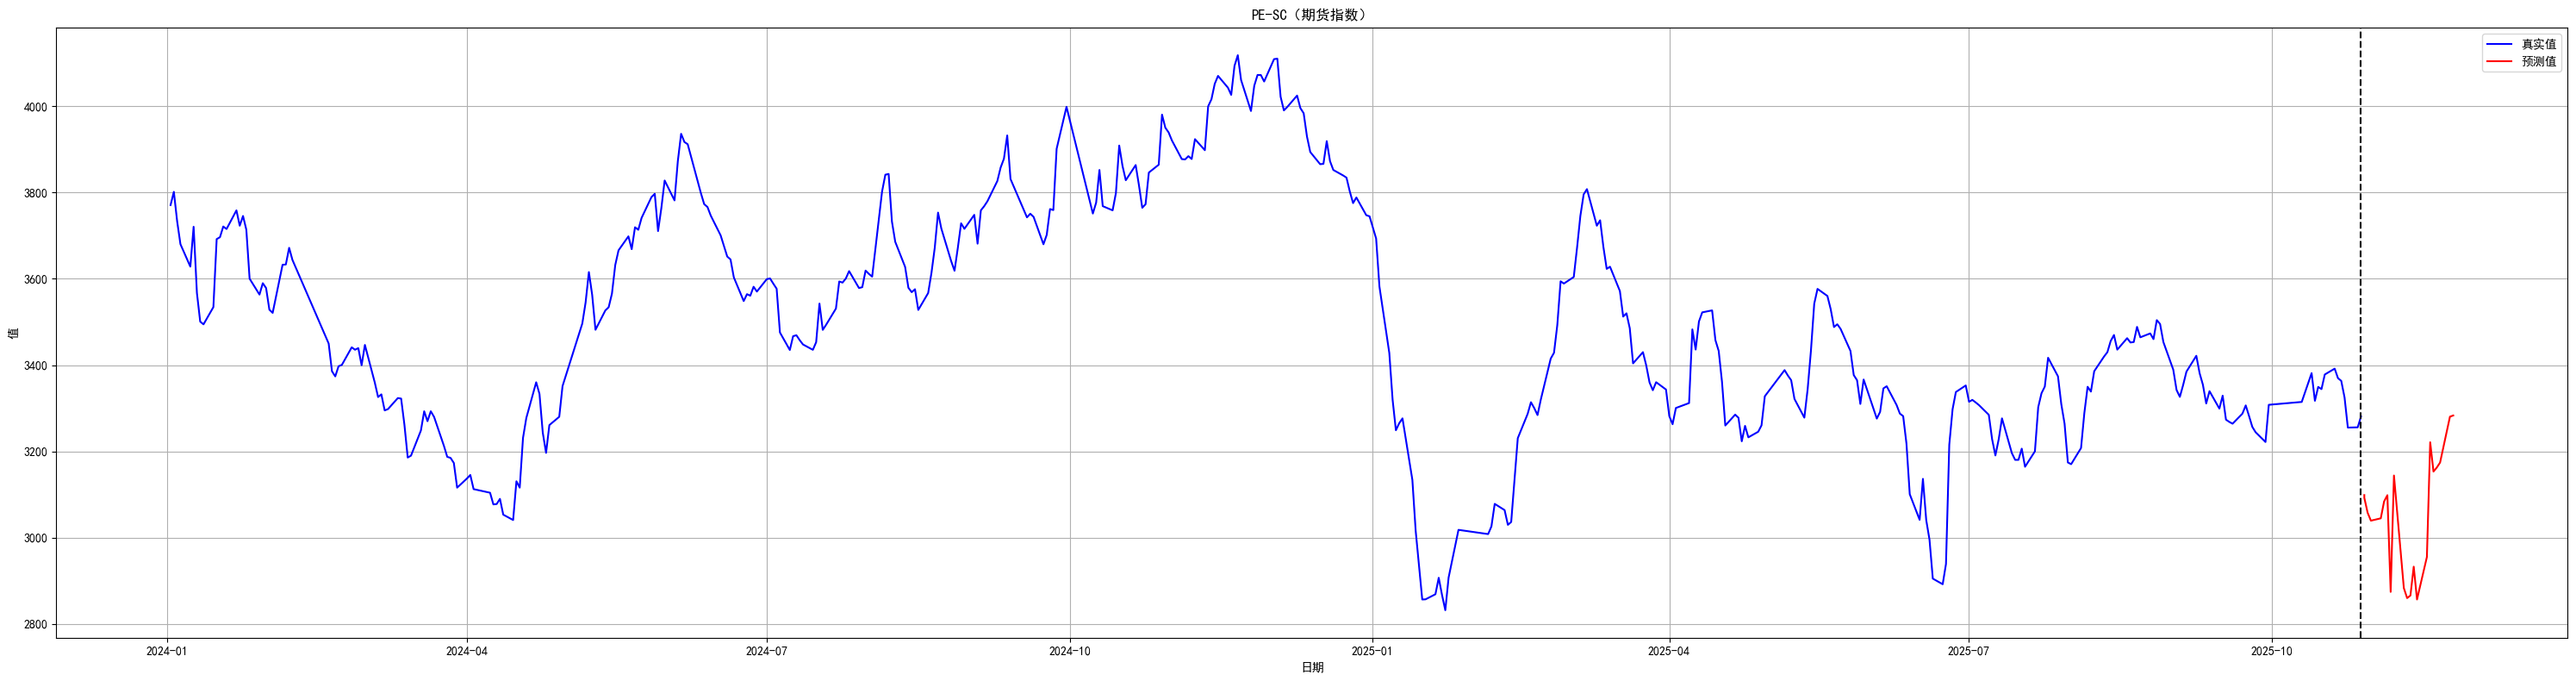

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 筛选2024年之后的数据
merged_df_daily_plot = merged_df_daily_plot[merged_df_daily_plot['Date'] >= '2024-01-01']

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['PE-SC（期货指数）'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['PE-SC（期货指数）_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('PE-SC（期货指数）')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "PE-SC（期货指数）"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else: 
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "PE-SC（期货指数）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
